In [2]:
import numpy as np
import matplotlib as mpl
#mpl.use('WebAgg')
import matplotlib.pyplot as plt
from math import pi, sin, cos, tan
import numpy.linalg as la
%matplotlib inline

In [3]:
#fc = 128
fc=12
#fc=2
hfc = fc//2
f = fc//2+1

def dirichlet(z):
    res = 0
    for m in range(-f, f+1):
        res += np.exp(2j*np.pi*m*z)
    return res

def fejer(z):
    res = 1
    for m in range(1,f):
        res += 2*(1-m/f)*np.cos(2*np.pi*m*z)
    return res


def fejer_dz(z):
    res = 0
    for m in range(1,f):
        res += -2*2*np.pi*m*(1-m/f)*np.sin(2*np.pi*m*z)
    return res

def kernel(z):
    return fejer(z)**2/f**2

@np.vectorize
def kernel2(z):
    if z == 0:
        return 1.0
    else:
        return (sin(f*pi*z)/(f*sin(pi*z)))**4
    
# cf. Candès et al. Appendix B
@np.vectorize
def kernel_dz2(z):
    if z == 0:
        return 0.0
    else:
        a = sin(f*pi*z)/(f*sin(pi*z))
        b = cos(f*pi*z)/sin(pi*z)
        c = sin(f*pi*z)*cos(pi*z)/(f*sin(pi*z)**2)
        return 4*pi * a**3 * (b-c)

def kernel_dz(z):
    return 2*fejer(z)*fejer_dz(z)/f**2
    """if z == 0:
        return 0.0
    else:
        a = sin(f*pi*z)/(f*sin(pi*z))
        b = cos(f*pi*z)/sin(pi*z)
        c = sin(f*pi*z)*cos(pi*z)/(f*sin(pi*z)**2)
        return 4*pi * a**3 * (b-c)"""

@np.vectorize
def kernel_dzz(z):
    if z == 0:
        return -pi**2 * fc*(fc+4)/3
    else:
        a = sin(f*pi*z)**2/(f**2 * sin(pi*z)**4)
        b = sin(f*pi*z)*cos(pi*z)/(f*sin(pi*z))
        c = sin(2*f*pi*z)/(f*tan(pi*z))
        d = sin(f*pi*z)**2/(f**2*tan(pi*z)**2)
        e = sin(f*pi*z)**2/(f**2*sin(pi*z)**2)
        return 4*pi**2 * a * (3*(cos(f*pi*z) - b)**2 - sin(f*pi*z)**2 - c + d + e)

In [3]:
print(kernel(0.94), fejer(0.94)**2/f**2)
print(f*sin(pi*0.94))

0.297337970182164 0.297337970182164
1.311669202100075


In [4]:
#Dx = 1.87/fc
Dx = 2/fc
print("fc={}, Delta x range=[{:.3f},{:.3f}]".format(fc, 1.87/fc, 0.5*(1-1.97/fc)))
#supp1 = np.array([0, Dx, 2*Dx])
supp1 = np.array([0.1, 0.2, 0.4])
N = len(supp1)

fc=12, Delta x range=[0.156,0.418]


In [5]:
class DualPoly:
    def __init__(self, a, b):
        self.a = a
        self.b = b
    def __call__(self, z):
        res = 0
        for j in range(N):
            #print("poly",z-supp1[j], kernel(z-supp1[j]), kernel_dz(z-supp1[j]))
            res += self.a[j]*kernel(z-supp1[j]) + self.b[j]*kernel_dz(z-supp1[j])
        return res

In [6]:
class DPFactory:
    def __init__(self, supp):
        D0, D1, D2 = np.empty((3, N, N))
        for j in range(N):
            for k in range(N):
                D0[j,k] = kernel(supp[j]-supp[k])
                D1[j,k] = kernel_dz(supp[j]-supp[k])
                D2[j,k] = kernel_dzz(supp[j]-supp[k])
        self.M = np.block([[D0, D1],
                      [D1, D2]])
    def __call__(self, eta):
        coefs = la.solve(self.M, np.hstack((eta, np.zeros_like(eta))))
        a = coefs[:N]
        b = coefs[N:]
        return DualPoly(a, b)

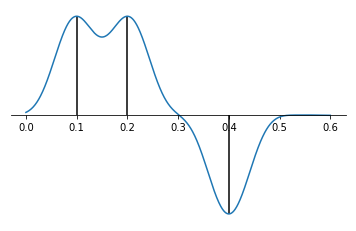

In [8]:
#%matplotlib tk
eta = [1,1,-1]
dp = DPFactory(supp1)(eta)
def part_poly(j, z):
    return dp.a[j]*kernel(z-supp1[j])# + dp.b[j]*kernel_dz(z-supp1[j])
zs = np.linspace(0,0.6,1000)
for k in range(N):
    plt.gca().vlines(supp1[k], 0, eta[k])
    #plt.plot(zs, part_poly(k, zs))
plt.plot(zs, dp(zs))
ax=plt.gca()
#ax.spines['left'].set_position(('data', 0.0))
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.get_yaxis().set_visible(False)
#plt.savefig('img/dp_ex_1d.pgf', bbox_inches='tight')
plt.show()

0.0
2.4727962823784536e-10


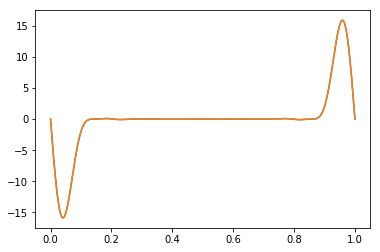

In [9]:
#zs = np.linspace(-2/fc,2/fc,1000)
zs = np.linspace(0,1,1000)
plt.plot(zs, kernel_dz(zs))
plt.plot(zs, kernel_dz2(zs))
#plt.plot(zs, kernel(zs))
#plt.plot(zs, fejer(zs)**2/f**2)
#plt.plot(zs, kernel(zs)-fejer(zs)**2/(f+1)**2)
print(zs[np.argmax(kernel(zs)-fejer(zs)**2/(f+1)**2)])
print(np.linalg.norm(kernel_dz(zs)-kernel_dz2(zs)))
#plt.savefig('img/kernel.pdf', bbox_inches='tight')
plt.show()

In [10]:
def test_derivs():
    zs, dz = np.linspace(-0.9/fc,0.9/fc,1000, retstep=True)
    vals = (kernel(zs[1:]) - kernel(zs[:-1]))/dz
    dvals = kernel_dz(zs[:-1])
    print(la.norm(dvals-vals))
    plt.plot(zs[1:], vals)
    plt.plot(zs[1:], dvals)
    plt.show()
    

0.8596617949680135


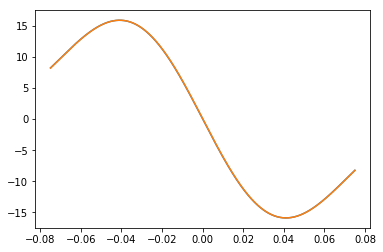

In [11]:
test_derivs()

In [6]:
eps = 0.08
etas = np.array([[1-eps,1,1-eps],
                 [1+2*eps, 1, 1+2*eps],
                 [1-eps, 1, 1-eps]])
polys = []
for k in range(3):
    coefs = la.solve(M, np.hstack((etas[k], np.zeros_like(etas[k]))))
    a = coefs[:N]
    b = coefs[N:]
    '''def poly(z):
        res = 0
        for j in range(N):
            res += a[j]*kernel(z-supp1[j]) + b[j]*kernel_dz(z-supp1[j])
        return res'''
    polys.append(DualPoly(a, b))

for poly in polys:
    print(poly(supp1))

[0.92 1.   0.92]
[1.16 1.   1.16]
[0.92 1.   0.92]


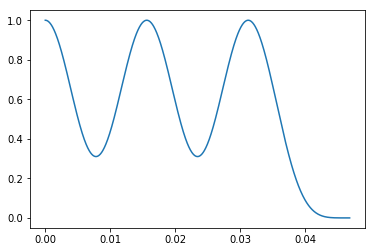

In [190]:
zs = np.linspace(0,3*Dx,1000)
plt.plot(zs, poly(zs))
plt.show()

In [8]:
def poly_2d(z1, z2):
    return poly(z1)*np.cos(2*pi*z2)

In [154]:
plot2d([-Dx, 3*Dx], [-1, 1], poly_2d)

NameError: name 'poly' is not defined

In [9]:
K = 1
tau = 1
tsteps = np.arange(-K,K+1)
def poly_dyn(x,v):
    res = 0
    for i, k in enumerate(tsteps):
        res += polys[i](x+tau*k*v)
    return res/(2*K+1)

In [10]:
%matplotlib tk
plot2d([-3*Dx,3*Dx],[-3*Dx,3*Dx],poly_dyn)

In [11]:
poly_dyn(Dx,0)

0.9999999999999999

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


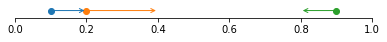

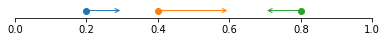

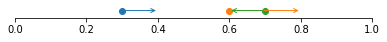

In [12]:
suppd = np.array([(0.2,0.1), (0.4,0.2), (0.8, -0.1)])
tsteps = [-1,0,1]
dt = 1
h = 1
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
print(colors)
for k in tsteps:
    fig = plt.figure(figsize=(6.4,0.2))
    #fig.figaspect(5)
    ax=plt.gca()
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(0,1.5)
    #ax.set_ylim(bottom=-0.1, top=0.1)
    #ax.spines['left'].set_position(('data', 0.0))
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.get_yaxis().set_visible(False)
    #plt.plot(suppd[:,0]+k*dt*suppd[:,1],np.zeros_like(supp1), ".", markersize=12, color=['red','green','blue'])
    #plt.scatter(suppd[:,0]+k*dt*suppd[:,1],np.zeros_like(supp1), marker=".", s=, c=['red','green','blue'])
    for i, p in enumerate(suppd):
        pos = p[0]+k*dt*p[1]
        plt.plot(pos,[h], ".", markersize=12, color=colors[i])
        #plt.arrow(pos, h, p[1], 0, head_width=0.05)
        ax.annotate("", xy=(pos+p[1], h), xytext=(pos, h), arrowprops=dict(arrowstyle="->",color=colors[i]))
    #plt.savefig('img/dyn_1d_step'+str(k)+'.pdf', bbox_inches='tight')
    plt.show()
#plt.savefig('img/dp_ex_1d.pdf', bbox_inches='tight')
#plt.title('test', position=(0,0.5))
plt.show()

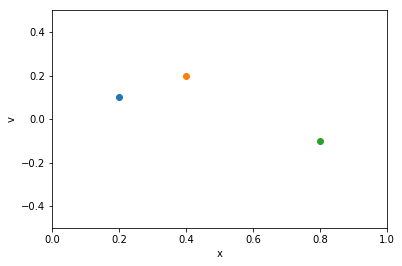

In [57]:
ax = plt.gca()
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 0.5)
for p in suppd:
    plt.plot(p[0], p[1], ".", markersize=12)
#plt.savefig('img/dyn_1d_phase.pdf', bbox_inches='tight')

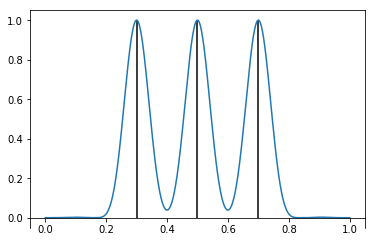

In [127]:
#suppd = np.array([(0.3,0),(0.5,0),(0.7,0)]
supp1 = [0.3, 0.5, 0.7]
eta=[1,1,1]
dp = DPFactory(supp1)(eta)
zs = np.linspace(0,1,1000)
for k in range(N):
    plt.gca().vlines(supp1[k], 0, eta[k])
    #plt.plot(zs, part_poly(k, zs))
plt.plot(zs, dp(zs))
ax=plt.gca()
#ax.spines['left'].set_position(('data', 0.0))
#ax.spines['left'].set_color('none')
ax.spines['bottom'].set_position(('data', 0.0))
#ax.spines['right'].set_color('none')
#ax.spines['top'].set_color('none')
#ax.get_yaxis().set_visible(False)
#plt.savefig('img/dp_ex_1d.pgf', bbox_inches='tight')
#plt.show()
plt.savefig('img/cert_stat3.pdf', bbox_inches='tight')

In [13]:

    
def plot2d(xrange, yrange, func, num=100):
    x = np.linspace(*xrange, num)
    y = np.linspace(*yrange, num)
    @mpl.ticker.FuncFormatter
    def xtick_format(st, pos):
        st = int(st)
        return "{:.1f}".format(x[np.clip(st, 0, num-1)])
    @mpl.ticker.FuncFormatter
    def ytick_format(st, pos):
        st = int(st)
        return "{:.1f}".format(y[np.clip(st, 0, num-1)])
    #print(y)
    xs, ys = np.meshgrid(x, y)
    #print(ys)
    vals = func(xs, ys)
    plt.pcolormesh(xs, ys, vals)
    #plt.imshow(vals, vmin=0, vmax=1)
    plt.colorbar()
    #plt.gca().xaxis.set_major_formatter(xtick_format)
    #plt.gca().yaxis.set_major_formatter(ytick_format)
    #plt.xticks([99])
    #plt.xlim(0,num-1)
    locs, labels = plt.xticks()
    locs[locs==num] = num-1
    #plt.xticks(locs)
    #plt.xlim(0,num-1)
    locs, labels = plt.yticks()
    locs[locs==num] = num-1
    #plt.yticks(locs)
    #plt.ylim(0,num-1)
    
    #plt.xticks(np.append(plt.xticks()[0], num-1))
    #plt.xticks([0,20,40,60,80,99,100])
    ax=plt.gca()
    plt.clim(0, 1)
    #plt.show()
    #print(ax.get_xticks())
    #locs, labels = plt.yticks()
    #print(locs, labels)
    #print(ys[locs])
    #plt.xticks(range(num), x)
    #plt.show()

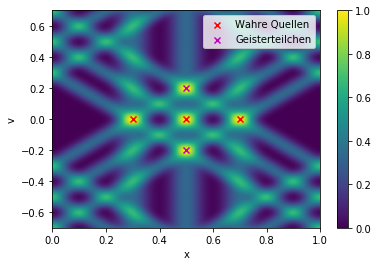

In [125]:
tsteps = [-1,0,1]
dt = 1
def dp_dyn(x, v):
    #print(x,v)
    res = 0
    for k in tsteps:
        res += dp(x+k*dt*v) / len(tsteps)
        #print(res)
    #idx = np.unravel_index(np.argmax(res), res.shape)
    #print(x[idx],v[idx], np.max(res),dp(x[idx]-v[idx]),x[idx]-v[idx])
    return res
plot2d([0,1],[-0.7,0.7], dp_dyn, 1000)
plt.xlabel('x')
plt.ylabel('v')
for x in supp1:
    h1 = plt.scatter(x, 0, c='r', marker='x', label='Wahre Quellen')
ghost = [(0.5,0.2), (0.5,-0.2)]
for x,v in ghost:
    h2 = plt.scatter(x, v, c='m', marker='x', label='Geisterteilchen')
plt.legend(handles=[h1,h2])
#plt.savefig('img/avg_cert_stat3.pdf', bbox_inches='tight')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

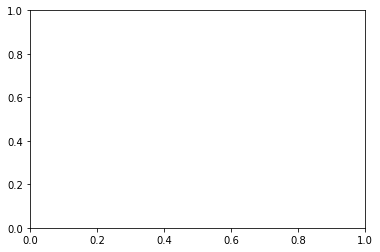

In [38]:
plt.yticks()

In [51]:
kernel_dz(0.9999999999999998)

array(-1.28753467e+15)

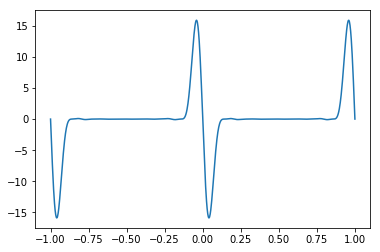

In [151]:
zs = np.linspace(-1,1.0,1000)
plt.plot(zs, kernel_dz(zs))
#plt.savefig('img/kernel.pdf', bbox_inches='tight')
plt.show()

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


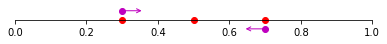

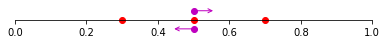

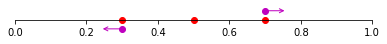

In [144]:
suppd = np.array([(0.2,0.1), (0.4,0.2), (0.8, -0.1)])
tsteps = [-1,0,1]
dt = 1
h = 1
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
print(colors)
for k in tsteps:
    fig = plt.figure(figsize=(6.4,0.5))
    #fig.figaspect(5)
    ax=plt.gca()
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(-1.5,1.5)
    #ax.set_ylim(bottom=-0.1, top=0.1)
    #ax.spines['left'].set_position(('data', 0.0))
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.get_yaxis().set_visible(False)
    #plt.plot(suppd[:,0]+k*dt*suppd[:,1],np.zeros_like(supp1), ".", markersize=12, color=['red','green','blue'])
    #plt.scatter(suppd[:,0]+k*dt*suppd[:,1],np.zeros_like(supp1), marker=".", s=, c=['red','green','blue'])
    for i, p in enumerate(supp1):
        plt.plot(p,[0], ".", markersize=12, color='r')
        #plt.arrow(pos, h, p[1], 0, head_width=0.05)
        #ax.annotate("", xy=(pos+p[1], h), xytext=(pos, h), arrowprops=dict(arrowstyle="->",color=colors[i]))
    #plt.savefig('img/dyn_1d_step'+str(k)+'.pdf', bbox_inches='tight')
    for x, v, y in [(0.5, 0.2, 1), (0.5, -0.2, -1)]:
        pos = x+k*dt*v
        plt.plot(pos, y, ".", markersize=12, color='m')
        ax.annotate("", xy=(pos+v*0.3, y), xytext=(pos, y), arrowprops=dict(arrowstyle="->",color='m'))
    plt.savefig('img/dyn_1d_ghost_step'+str(k)+'.pdf', bbox_inches='tight')
    plt.show()
#plt.savefig('img/dp_ex_1d.pdf', bbox_inches='tight')
#plt.title('test', position=(0,0.5))
#plt.show()

In [5]:
def barecrossfig(xlab, ylab):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    #ax.set_xlabel('x')
    #ax.set_ylabel('v')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1,1)
    ax.spines['left'].set_position(('data', 0.0))
    #ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlab, x=1)
    ax.set_ylabel(ylab, y=1, rotation=0)
    return fig, ax

In [6]:
def thetaproj(supp, theta, xlab, ylab):
    fig, ax = barecrossfig(xlab, ylab)

    #theta = np.array((1,1))/np.sqrt(2)
    for p in supp:
        color = next(ax._get_lines.prop_cycler)['color']
        ax.plot(p[0], p[1], "o", color=color)
        proj = theta*(theta@p)
        ax.plot(*proj[...,np.newaxis], "o", fillstyle='none', color=color)
        ax.plot([p[0], proj[0]], [p[1], proj[1]], linestyle='dashed', color=color)
    ax.annotate("", xy=theta, xytext=-theta, arrowprops=dict(arrowstyle="->",color='m'))
    ax.annotate(r"$\theta$", xy=theta, xytext=theta, color='m')
    #plt.show()
#plt.savefig('img/dyn_1d_phase.pdf', bbox_inches='tight')

In [3]:
supp2d = np.array([
    [0.5, 0.5, 0.2, 0.2],
    [0.2, 0.3, 0.1, -0.2],
    [0.8, 0.2, -0.1, -0.1]
])
"""supp2d = np.array([
    [0.0, 0.0, 0.2, 0.0],
    [0.0, 0.0, 0.1, 0.0],
    [0.1, 0.0, 0.2, 0.0],
    [0.1, 0.0, 0.0, 0.0],
    [0.2, 0.0, 0.1, 0.0],
    [0.2, 0.0, 0.0, 0.0]
])"""


'supp2d = np.array([\n    [0.0, 0.0, 0.2, 0.0],\n    [0.0, 0.0, 0.1, 0.0],\n    [0.1, 0.0, 0.2, 0.0],\n    [0.1, 0.0, 0.0, 0.0],\n    [0.2, 0.0, 0.1, 0.0],\n    [0.2, 0.0, 0.0, 0.0]\n])'

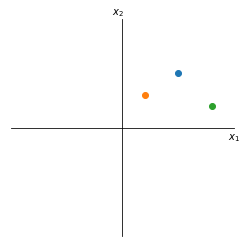

In [36]:
fig, ax = barecrossfig("$x_1$", "$x_2$")
for p in supp2d:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(p[0], p[1], "o", color=color)
plt.savefig('img/phase2d_x.pdf', bbox_inches='tight')
plt.show()

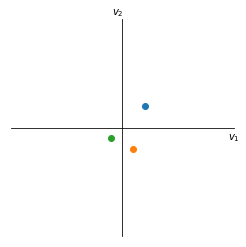

In [37]:
fig, ax = barecrossfig("$v_1$", "$v_2$")
for p in supp2d:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(p[2], p[3], "o", color=color)
plt.savefig('img/phase2d_v.pdf', bbox_inches='tight')
plt.show()

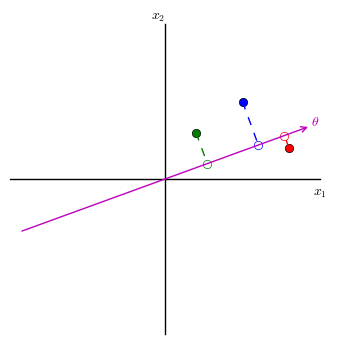

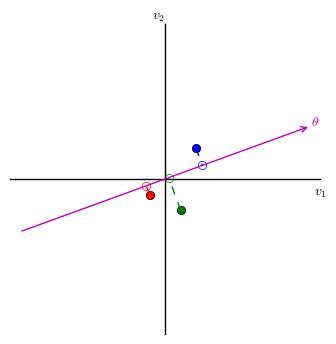

In [7]:
#theta = np.array((1,1))/np.sqrt(2)
alpha = 20
theta = np.array((np.cos(alpha*np.pi/180), np.sin(alpha*np.pi/180)))
thetaproj(supp2d[:,:2], theta, '$x_1$', '$x_2$')
plt.savefig('img/phase2d_proj_x'+str(alpha)+'.pdf', bbox_inches='tight')
thetaproj(supp2d[:,2:], theta, '$v_1$', '$v_2$')
plt.savefig('img/phase2d_proj_v.pdf'+str(alpha)+'.pdf', bbox_inches='tight')

In [6]:
%matplotlib tk
zs = np.linspace(-0.5,0.5,1000)
plt.plot(zs, dirichlet(zs))
plt.show()

/home/alex/.local/lib/python3.5/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
